In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy_financial as npf
import datetime as dt
import cpi
from calendar import isleap
from utils.time import convert_to_decimal_year, convert_to_datetime
from utils.data import zero_pad, rgb_tuple
from typing import List, Union
from utils.time import convert_multiple_formats_to_datetime
import geopandas as gpd
from geopy import distance
from geopy.distance import great_circle
import json
from random import randint
import warnings
import geopandas as gpd
from projects.ccs.ccs_project import CCSProject
from pathlib import Path
from projects.ccs.ccs_costs import costs #bespoke function to compute updated costs for capture, transport, and storage

warnings.filterwarnings("ignore")
%load_ext jupyter_black



The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


### Get the data!

In [9]:
DATA_DIR = Path("/Volumes/Samsung_T5/data/")

brent_df = pd.read_csv(
    DATA_DIR / Path("oilgas/brent_oil_prices_2023_dollars.csv"),
    parse_dates=["date"],
)
brent_df["year"] = brent_df["year"].astype(int)

# compute costs for all industries on the fly using costs fuc
all_industries_gdf, costs_df = costs(
    "/Users/lindseygulden/dev/leg-up/config/ccs_cost_info.yml",
    output_dir="/Volumes/Samsung_T5/data/ccs",
)

rhg_oil_cases_df = pd.read_csv(
    DATA_DIR / Path("ccs/rhg_oil_price_cases_brent_crude_2023_usd.csv"), index_col=[0]
)
scenarios_df=pd.read_csv(DATA_DIR / Path('ccs/ues_simulations.csv'))

### Figure showing time series of Brent prices (both daily and the 365-day rolling mean), all adjusted to 2023 dollars

(6360.0, 19417.0)

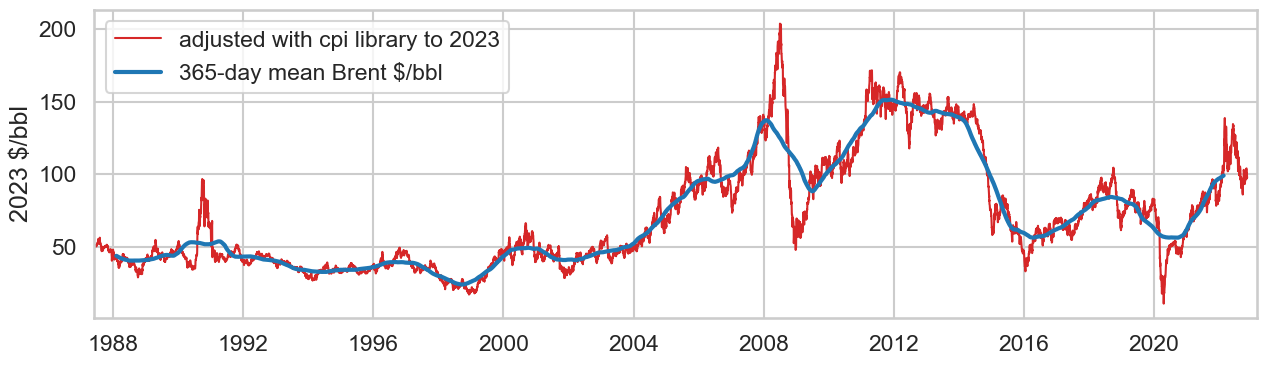

In [330]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.subplot(1, 1, 1)
plt.plot(
    brent_df.date,
    brent_df.usd_cpi_2023,
    color="tab:red",
    lw=1.5,
    label="adjusted with cpi library to 2023",
)
plt.plot(
    brent_df.date,
    brent_df.rolling_annual_average_usd_per_unit,
    color="tab:blue",
    lw=3,
    label="365-day mean Brent $/bbl",
)
plt.grid(True)
plt.ylabel("2023 $/bbl")
plt.legend()
plt.xlim([dt.datetime(1987, 6, 1), dt.datetime(2023, 3, 1)])

### Figure showing side-by-side comparison of the distribution of brent 365-rolling-mean prices and the RHG cases

Text(0, 0.5, '')

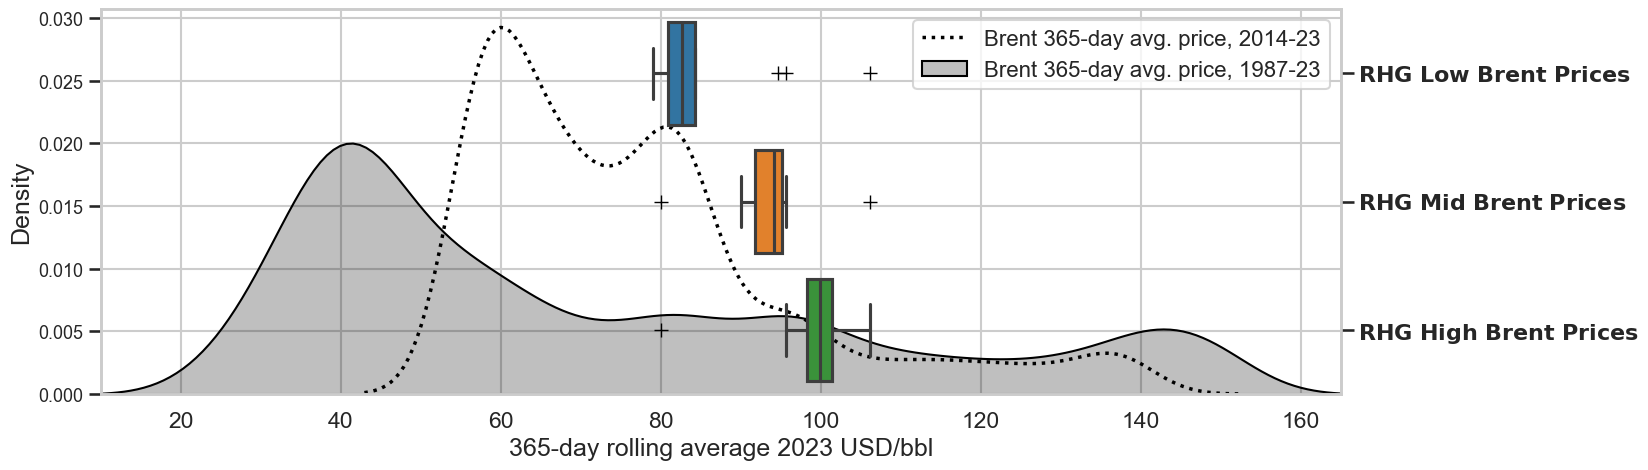

In [344]:
# Turn rhg oil price cases into a long-form dataset so that we can use seaborn's hue functionalty
rhg_cases_longform_df = rhg_oil_cases_df.melt(
    value_vars=["low", "mid", "high"],
    value_name="usd_per_bbl",
    var_name="rhg_emissions_case",
)

common_norm = False
sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.set_xlim([10, 165])
sns.kdeplot(
    data=brent_df.loc[(brent_df["year"] > 2013)],
    x="rolling_annual_average_usd_per_unit",
    common_norm=common_norm,
    fill=False,
    ax=ax,
    ls=":",
    lw=2.5,
    color="black",
    label="Brent 365-day avg. price, 2014-23",
)


sns.kdeplot(
    data=brent_df.loc[(brent_df["year"] > 1986)],
    x="rolling_annual_average_usd_per_unit",
    common_norm=common_norm,
    fill=True,
    ax=ax,
    color="black",
    label="Brent 365-day avg. price, 1987-23",
)

ax2 = ax.twinx()

flierprops = dict(
    marker="+", markerfacecolor="None", markersize=10, markeredgecolor="black"
)


sns.boxplot(
    data=rhg_cases_longform_df,
    x="usd_per_bbl",
    y="rhg_emissions_case",
    ax=ax2,
    flierprops=flierprops,
)
l = ax.get_yticklabels()
ax.set_yticklabels(l, fontsize=13)
ax.legend(fontsize=16)
ax.grid(True)
ax.set_xlabel("365-day rolling average 2023 USD/bbl")

ax2.set_yticklabels(
    [
        r"$\bf{" + "RHG\ Low\ Brent\ Prices" + "}$",
        r"$\bf{" + "RHG\ Mid\ Brent\ Prices" + "}$",
        r"$\bf{" + "RHG\ High\ Brent\ Prices" + "}$",
    ],
    fontsize=16,
)
ax2.set_ylabel("")

In [345]:
# Project parameters for RHG cases:
from pathlib import Path
from utils.io import yaml_to_dict

config = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up/config/rhg_scenarios.yml",
)


# import costs data
costs_df = pd.read_csv(config["costs_file"], index_col="industry")
industries = list(costs_df.index)

# import digitized RHG oil cases
rhg_oil_cases_df = pd.read_csv(config["rhg_oil_cases_file"])

# for each specified industry, run unit-economics simulator for each of the three
# Rhodium scenarios (low, mid, and high Emissions pathways, as described in May 2024 report)
scenario_list = []
parameter_list = []
for industry in industries:
    rhg_low_emissions_pathway_params = {
        "project_length_yrs": config["project_length_yrs"],
        "inflation_rate": config["low_inflation_rate"],
        "discount_rate": config["discount_rate"],
        "industry": industry,
        "tco2_sequestered_per_yr": config["tco2_sequestered_per_yr"],
        "oil_prices": list(rhg_oil_cases_df["high"]),
        "oil_breakeven_price": config["oil_breakeven_price"],
        "capture_cost_usd_per_tco2": costs_df.loc[industry, "capture_low_usd_per_tco2"],
        "transport_cost_usd_per_tco2": costs_df.loc[industry, "transport_usd_per_tco2"]
        * config["low_price_scalar"],  # transport_low,
        "storage_cost_usd_per_tco2": costs_df.loc[industry, "storage_usd_per_tco2"]
        * config["low_price_scalar"],
        "rhg_emissions_pathway": "low",
        "cost_method": "defined",
        "revenue_method": "computed",
    }

    rhg_mid_emissions_pathway_params = {
        "project_length_yrs": config["project_length_yrs"],
        "inflation_rate": config["low_inflation_rate"],
        "discount_rate": config["discount_rate"],
        "industry": industry,
        "tco2_sequestered_per_yr": config["tco2_sequestered_per_yr"],
        "oil_prices": list(rhg_oil_cases_df["mid"]),
        "oil_breakeven_price": config["oil_breakeven_price"],
        "capture_cost_usd_per_tco2": costs_df.loc[
            industry, "capture_center_usd_per_tco2"
        ],
        "transport_cost_usd_per_tco2": costs_df.loc[industry, "transport_usd_per_tco2"],
        "storage_cost_usd_per_tco2": costs_df.loc[industry, "storage_usd_per_tco2"],
        "rhg_emissions_pathway": "mid",
        "cost_method": "defined",
        "revenue_method": "computed",
    }

    rhg_high_emissions_pathway_params = {
        "project_length_yrs": config["project_length_yrs"],
        "inflation_rate": config["high_inflation_rate"],
        "discount_rate": config["discount_rate"],
        "industry": industry,
        "tco2_sequestered_per_yr": config["tco2_sequestered_per_yr"],
        "oil_prices": list(rhg_oil_cases_df["low"]),
        "oil_breakeven_price": config["oil_breakeven_price"],
        "capture_cost_usd_per_tco2": costs_df.loc[
            industry, "capture_high_usd_per_tco2"
        ],
        "transport_cost_usd_per_tco2": costs_df.loc[industry, "transport_usd_per_tco2"]
        * config["high_price_scalar"],  # transport_low,
        "storage_cost_usd_per_tco2": costs_df.loc[industry, "storage_usd_per_tco2"]
        * config["high_price_scalar"],
        "rhg_emissions_pathway": "high",
        "cost_method": "defined",
        "revenue_method": "computed",
    }
    parameter_list.append(
        [
            rhg_low_emissions_pathway_params,
            rhg_mid_emissions_pathway_params,
            rhg_high_emissions_pathway_params,
        ]
    )
    for params in [
        rhg_low_emissions_pathway_params,
        rhg_mid_emissions_pathway_params,
        rhg_high_emissions_pathway_params,
    ]:
        row_dict = {}
        row_dict["industry"] = industry
        row_dict["rhg_emissions_pathway"] = params["rhg_emissions_pathway"]

        project = CCSProject(params)
        row_dict["total_eor_usd_per_tco2"] = project.total_eor_usd_per_tco2
        row_dict["total_gs_usd_per_tco2"] = project.total_gs_usd_per_tco2
        scenario_list.append(row_dict)
scenarios_df = pd.DataFrame(scenario_list)

rhodium_2040_df = (
    pd.DataFrame(
        {
            "low": [52, 13, 14, 26, 16, 11, 8, 3],
            "mid": [52, 13, 13, 8, 0, 0, 0, 0],
            "high": [50, 12, 10, 0, 0, 0, 0, 0],
        },
        index=[
            "Ethanol",
            "Ammonia",
            "NG Processing",
            "Refinery",
            "Hydrogen",
            "Ethylene",
            "Iron/Steel",
            "Cement",
        ],
    )
    .reset_index()
    .melt(
        id_vars="index",
        value_vars=["low", "mid", "high"],
        var_name="rhg_emissions_pathway",
        value_name="MMtCO2_per_yr",
    )
)
rhodium_2040_df.rename(columns={"index": "industry"}, inplace=True)
rhodium_2040_df.to_csv(Path("output_dir"))

### Figure (re)plotting total 2040 Capacity MMtCO2 for each of the three emissions scenarios 
as reported in Fig. 3 of the 2024 RHG report

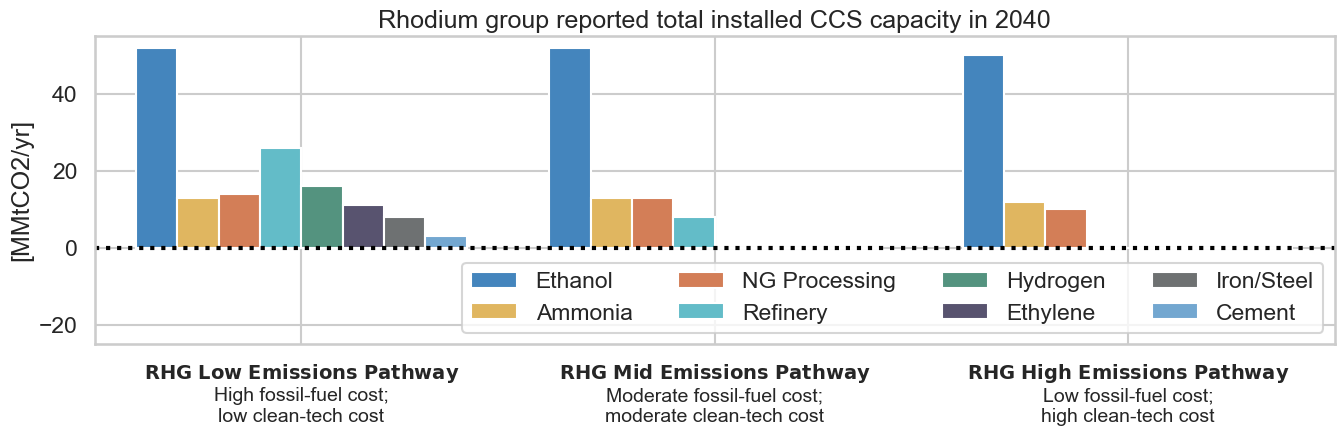

In [346]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")

palette = {
    "Ethanol": rgb_tuple(68, 133, 189),
    "Ammonia": rgb_tuple(224, 182, 96),
    "NG Processing": rgb_tuple(211, 126, 87),
    "Refinery": rgb_tuple(99, 188, 200),
    "Hydrogen": rgb_tuple(84, 147, 127),
    "Ethylene": rgb_tuple(88, 83, 111),
    "Iron/Steel": rgb_tuple(110, 113, 114),
    "Cement": rgb_tuple(115, 167, 208),
}
hue_order = list(palette.keys())
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.barplot(
    ax=ax,
    data=rhodium_2040_df,
    x="rhg_emissions_pathway",
    y="MMtCO2_per_yr",
    hue="industry",
    palette=palette,
    hue_order=hue_order,
    saturation=1,
)
plt.plot([-0.5, 2.5], [0, 0], "k", lw=3, ls=":")
ax.set_xlim([-0.5, 2.5])
ax.grid(True)
labels = ax.get_xticklabels()
ax.set_xticklabels(
    [
        r"$\bf{"
        + "RHG\ Low\ Emissions\ Pathway"
        + "}$"
        + "\nHigh fossil-fuel cost;\nlow clean-tech cost",
        r"$\bf{"
        + "RHG\ Mid\ Emissions\ Pathway"
        + "}$"
        + "\nModerate fossil-fuel cost;\nmoderate clean-tech cost",
        r"$\bf{"
        + "RHG\ High\ Emissions\ Pathway"
        + "}$"
        + "\nLow fossil-fuel cost;\nhigh clean-tech cost",
    ],
    fontsize=14,
)
ax.set_xlabel("")
ax.set_ylim([-25, 55])
ax.set_ylabel("[MMtCO2/yr]")
ax.set_title("Rhodium group reported total installed CCS capacity in 2040")
ax.legend(loc="lower right", ncol=4)

### Figure showing the CCS-EOR present unit value for each industry as simluated by UES for each RHG scenario

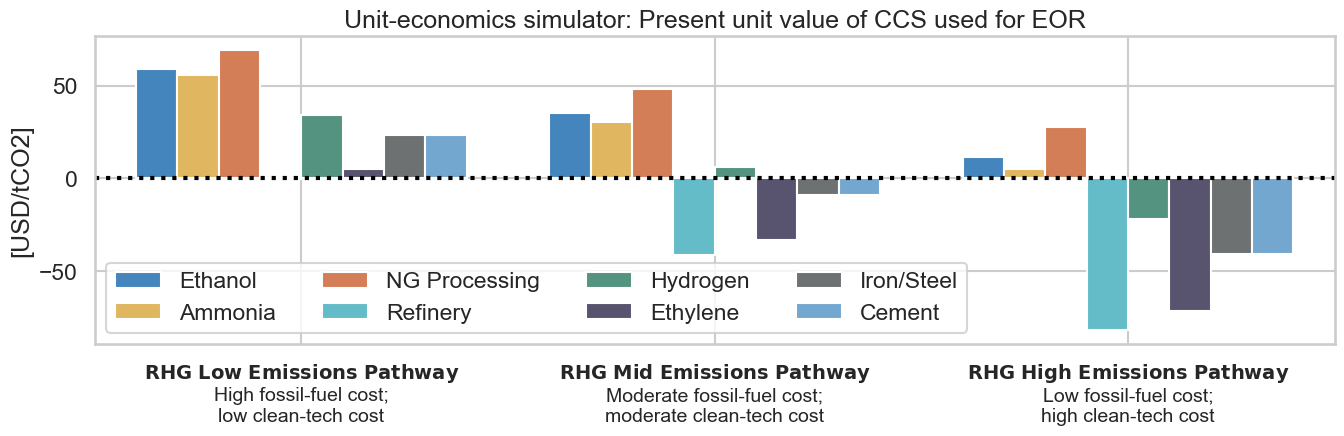

In [348]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")

palette = {
    "Ethanol": rgb_tuple(68, 133, 189),
    "Ammonia": rgb_tuple(224, 182, 96),
    "NG Processing": rgb_tuple(211, 126, 87),
    "Refinery": rgb_tuple(99, 188, 200),
    "Hydrogen": rgb_tuple(84, 147, 127),
    "Ethylene": rgb_tuple(88, 83, 111),
    "Iron/Steel": rgb_tuple(110, 113, 114),
    "Cement": rgb_tuple(115, 167, 208),
}
hue_order = list(palette.keys())
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.barplot(
    ax=ax,
    data=scenarios_df,
    x="rhg_emissions_pathway",
    y="total_eor_usd_per_tco2",
    hue="industry",
    palette=palette,
    hue_order=hue_order,
    saturation=1,
)
plt.plot([-0.5, 2.5], [0, 0], "k", lw=3, ls=":")
ax.set_xlim([-0.5, 2.5])
ax.grid(True)
labels = ax.get_xticklabels()
ax.set_xticklabels(
    [
        r"$\bf{"
        + "RHG\ Low\ Emissions\ Pathway"
        + "}$"
        + "\nHigh fossil-fuel cost;\nlow clean-tech cost",
        r"$\bf{"
        + "RHG\ Mid\ Emissions\ Pathway"
        + "}$"
        + "\nModerate fossil-fuel cost;\nmoderate clean-tech cost",
        r"$\bf{"
        + "RHG\ High\ Emissions\ Pathway"
        + "}$"
        + "\nLow fossil-fuel cost;\nhigh clean-tech cost",
    ],
    fontsize=14,
)
ax.set_xlabel("")
ax.set_ylabel("[USD/tCO2]")
ax.set_title("Unit-economics simulator: Present unit value of CCS used for EOR")
ax.legend(loc="lower left", ncols=4)

### Figure showing the CCS-GS present unit value for each industry as simluated by UES for each RHG scenario

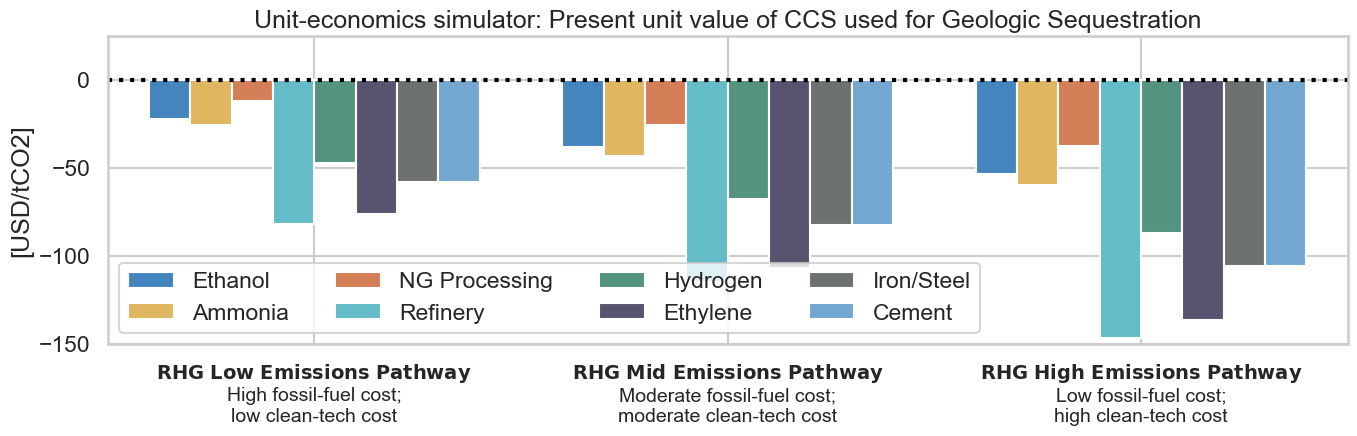

In [349]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")

palette = {
    "Ethanol": rgb_tuple(68, 133, 189),
    "Ammonia": rgb_tuple(224, 182, 96),
    "NG Processing": rgb_tuple(211, 126, 87),
    "Refinery": rgb_tuple(99, 188, 200),
    "Hydrogen": rgb_tuple(84, 147, 127),
    "Ethylene": rgb_tuple(88, 83, 111),
    "Iron/Steel": rgb_tuple(110, 113, 114),
    "Cement": rgb_tuple(115, 167, 208),
}
hue_order = list(palette.keys())
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.barplot(
    ax=ax,
    data=scenarios_df,
    x="rhg_emissions_pathway",
    y="total_gs_usd_per_tco2",
    hue="industry",
    palette=palette,
    hue_order=hue_order,
    saturation=1,
)
plt.plot([-0.5, 2.5], [0, 0], "k", lw=3, ls=":")
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([-150, 25])
ax.grid(True)
labels = ax.get_xticklabels()
ax.set_xticklabels(
    [
        r"$\bf{"
        + "RHG\ Low\ Emissions\ Pathway"
        + "}$"
        + "\nHigh fossil-fuel cost;\nlow clean-tech cost",
        r"$\bf{"
        + "RHG\ Mid\ Emissions\ Pathway"
        + "}$"
        + "\nModerate fossil-fuel cost;\nmoderate clean-tech cost",
        r"$\bf{"
        + "RHG\ High\ Emissions\ Pathway"
        + "}$"
        + "\nLow fossil-fuel cost;\nhigh clean-tech cost",
    ],
    fontsize=14,
)
ax.set_xlabel("")
ax.set_ylabel("[USD/tCO2]")
ax.set_title(
    "Unit-economics simulator: Present unit value of CCS used for Geologic Sequestration"
)
ax.legend(loc="lower left", ncols=4)

### Figure showing locations of industry facilities used to build average values for transport and storage costs, by industry


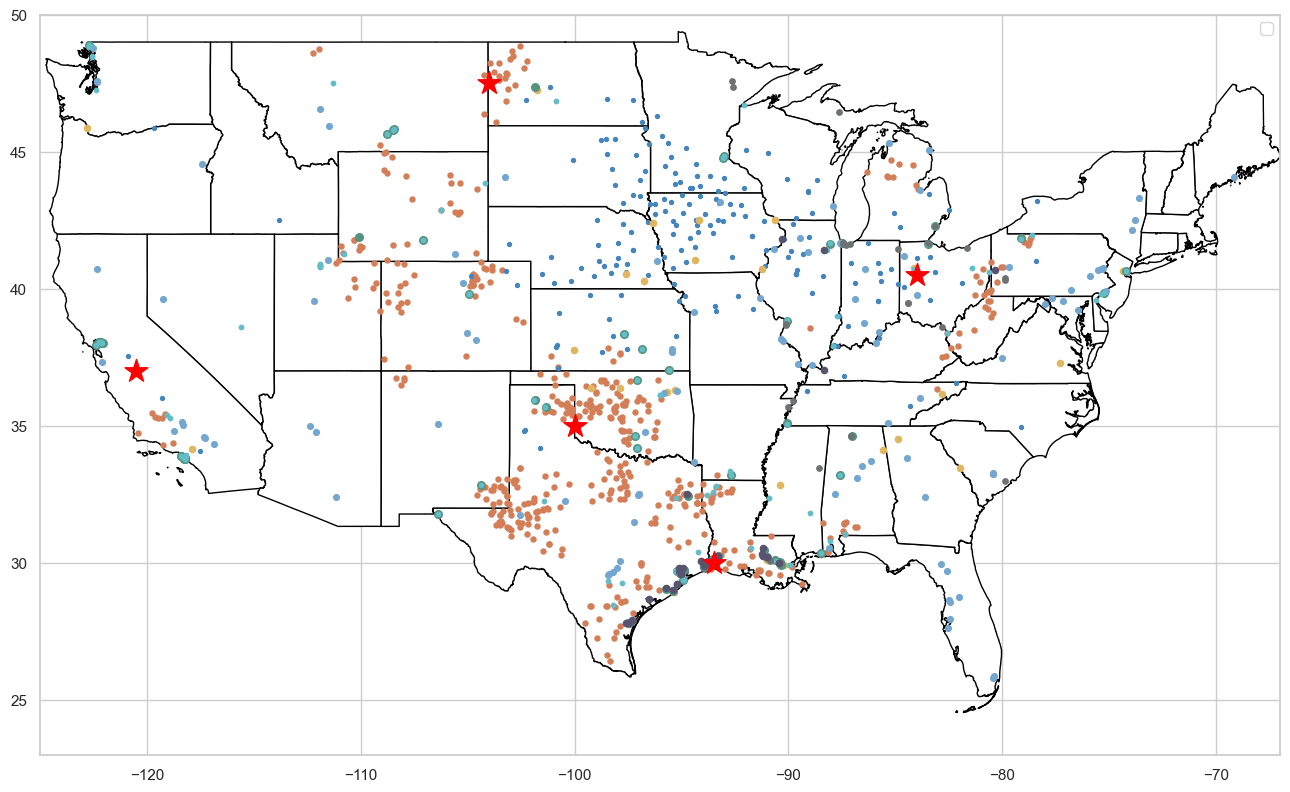

In [105]:

# get data

all_industries_gdf = gpd.read_file(
    DATA_DIR / "ccs/all_industry_facility_locations.geojson"
)
storage_gdf = gpd.read_file(
    DATA_DIR / "ccs/npc_storage_regions_representative_points.geojson"
)
markersize = {
    "Refinery": 10,
    "Ethylene": 20,
    "Ethanol": 8,
    "NG Processing": 13,
    "Ammonia": 20,
    "Cement": 17,
    "Hydrogen": 30,
    "Iron/Steel": 15,
}
us = gpd.read_file("/Volumes/Samsung_T5/data/us_geo/gz_2010_us_040_00_500k.json")
us.to_crs(crs="EPSG:4326", inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
us.plot(ax=ax, color="white", edgecolor="black")
for industry in industries:
    all_industries_gdf.loc[all_industries_gdf.industry == industry].plot(
        ax=ax, color=palette[industry], markersize=markersize[industry], legend=True
    )
storage_gdf.plot(
    ax=ax,
    color="red",
    marker="*",
    markersize=300,
)
ax.set_xlim([-125, -67])
ax.set_ylim([23, 50])


### Figure showing the distance to the nearest storage region and the count of different industry facilities in each region

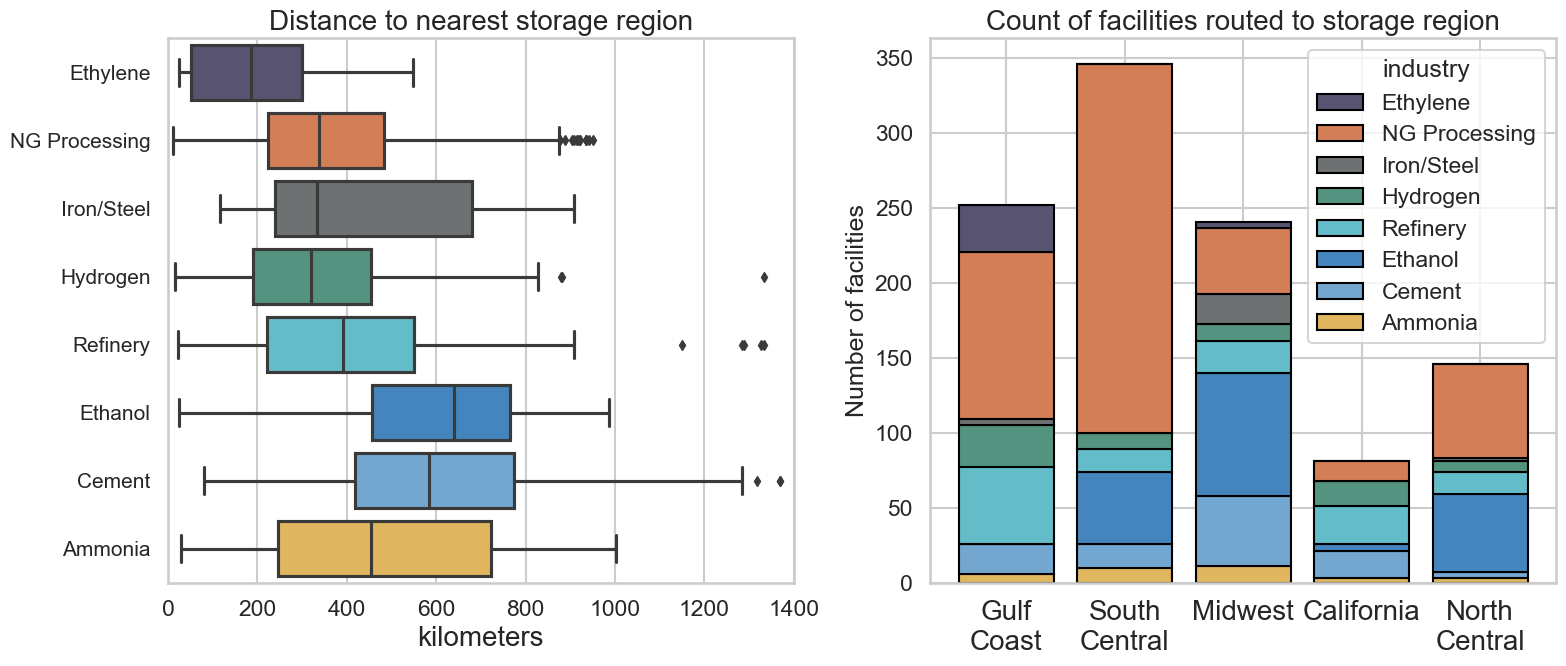

In [352]:
sns.set_context("talk")  # rc={"patch.linewidth": 1, "patch.edgecolor": "gray"})
sns.set_style("whitegrid")
hue_order = list(
    all_industries_gdf[["industry", "dist_to_storage_km"]]
    .groupby("industry")
    .mean()
    .sort_values(by="dist_to_storage_km")
    .index
)

regions = list(all_industries_gdf.storage_region.unique())

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.boxplot(
    data=all_industries_gdf,
    x="dist_to_storage_km",
    y="industry",
    ax=axes[0],
    palette=palette,
    order=hue_order,
    saturation=1,
)
axes[0].set_title("Distance to nearest storage region", fontsize=20)
axes[0].set_xlim([0, 1400])
axes[0].set_ylabel("")
axes[0].set_xlabel("kilometers", fontsize=20)
axes[0].set_yticklabels(labels=hue_order, fontsize=15)

# create stacked bar chart shwoing count of facilities routing to each region
sns.histplot(
    data=all_industries_gdf,
    x="storage_region",
    multiple="stack",
    shrink=0.8,
    hue="industry",
    alpha=1,
    ax=axes[1],
    palette=palette,
    hue_order=hue_order,
    ec="black",
)
axes[1].set_title("Count of facilities routed to storage region", fontsize=20)
axes[1].set_ylabel("Number of facilities")
axes[1].set_xlabel("")
axes[1].set_xticklabels([r.replace("_", "\n").title() for r in regions], fontsize=20)
fig.tight_layout()

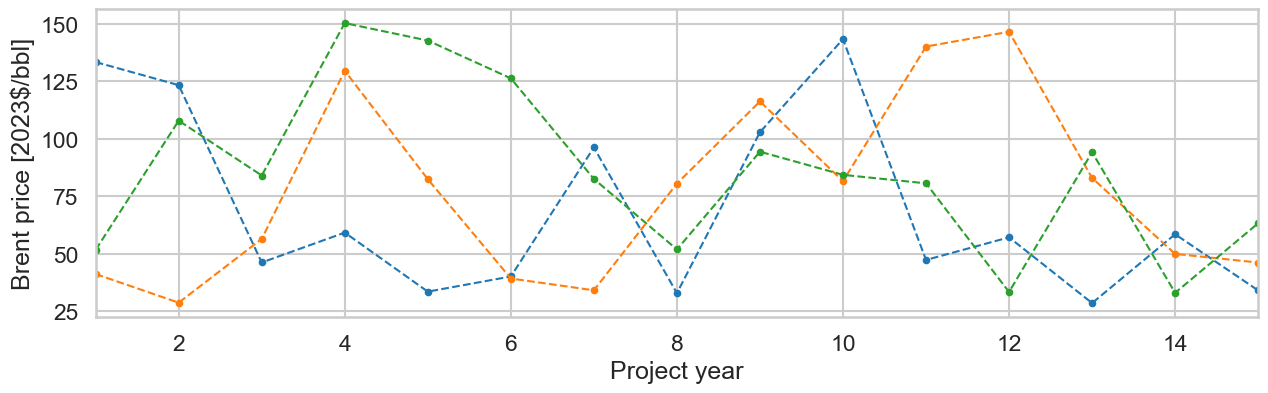

In [433]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.subplot(1, 1, 1)
for _ in range(3):
    oil_sample = list(
        brent_df.dropna().rolling_annual_average_usd_per_unit.sample(15, replace=True)
    )
    plt.plot(list(range(1, 16)), oil_sample, marker=".", linestyle="--", lw=1.5)
    plt.xlabel("Project year")
    plt.xlim([1, 15])
    plt.ylabel("Brent price [2023$/bbl]")

Text(0, 0.5, 'Density')

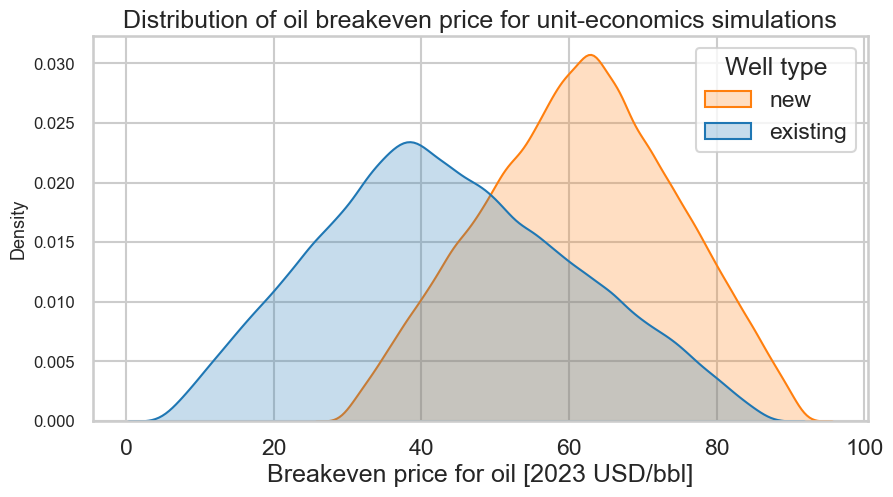

In [285]:
breakeven_prices_df = pd.read_csv(
    DATA_DIR
    / Path("ccs/breakeven_triangular_distribution_parameters_2023_usd_per_bbl.csv"),
    index_col=[0],
)
breakeven_distributions_df = pd.DataFrame(
    {
        "existing": np.random.triangular(
            left=breakeven_prices_df.loc["existing", "low"],
            mode=breakeven_prices_df.loc["existing", "mid"],
            right=breakeven_prices_df.loc["existing", "high"],
            size=150000,
        ),
        "new": np.random.triangular(
            left=breakeven_prices_df.loc["new", "low"],
            mode=breakeven_prices_df.loc["new", "mid"],
            right=breakeven_prices_df.loc["new", "high"],
            size=150000,
        ),
    }
).melt(
    value_vars=["existing", "new"],
    var_name="well type",
    value_name="breakeven_usd_per_bbl",
)

sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.kdeplot(
    data=breakeven_distributions_df,
    x="breakeven_usd_per_bbl",
    hue="well type",
    common_norm=False,
    fill=True,
    ax=ax,
)
ax.legend(
    title="Well type",
    labels=[
        "new",
        "existing",
    ],
)
ax.set_title("Distribution of oil breakeven price for unit-economics simulations")
ax.set_xlabel("Breakeven price for oil [2023 USD/bbl]")
l = ax.get_yticklabels()
ax.set_yticklabels(labels=l, fontsize=12)
ax.set_ylabel("Density", fontsize=13)

### Figure showing CCS cost sampling distributions used 

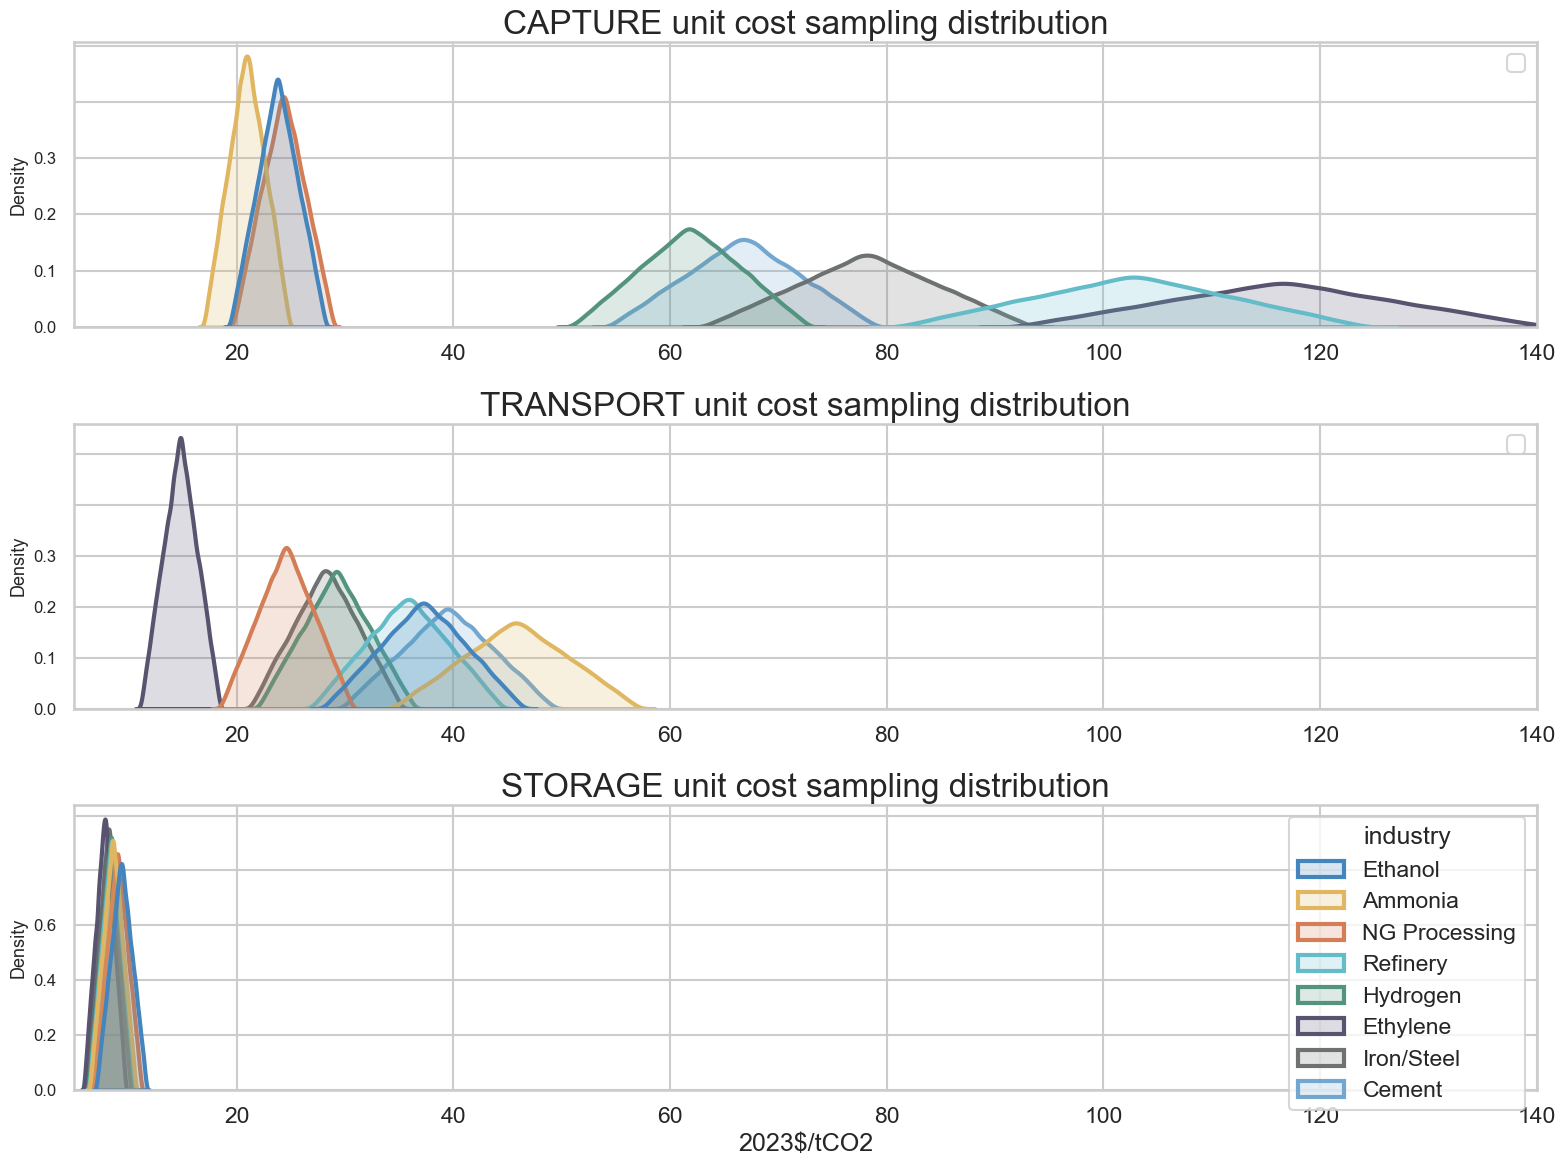

In [417]:
# build empirical representations of the triangular distributions used for PDFs for capture, transport, and storage costs
cost_dict = {}
transport_dict = {}
stor_dict = {}
for industry in industries:
    cost_dict = cost_dict | {
        industry: np.random.triangular(
            left=costs_df.loc[industry, "capture_low_usd_per_tco2"],
            mode=costs_df.loc[industry, "capture_center_usd_per_tco2"],
            right=costs_df.loc[industry, "capture_high_usd_per_tco2"],
            size=100000,
        )
    }
    transport_dict = transport_dict | {
        industry: np.random.triangular(
            left=costs_df.loc[industry, "transport_usd_per_tco2"] * 0.75,
            mode=costs_df.loc[industry, "transport_usd_per_tco2"],
            right=costs_df.loc[industry, "transport_usd_per_tco2"] * 1.25,
            size=100000,
        )
    }
    stor_dict = stor_dict | {
        industry: np.random.triangular(
            left=costs_df.loc[industry, "storage_usd_per_tco2"] * 0.75,
            mode=costs_df.loc[industry, "storage_usd_per_tco2"],
            right=costs_df.loc[industry, "storage_usd_per_tco2"] * 1.25,
            size=100000,
        )
    }
# assemble dictionaries into dataframes, longform for seaborn plotting
cost_distributions_df = pd.DataFrame(cost_dict)
cost_distributions_df["NG Processing"] = (
    cost_distributions_df["NG Processing"] + 0.5
)  # so visible on plot
cost_distributions_df = cost_distributions_df.melt(
    value_vars=industries,
    var_name="industry",
    value_name="capture_cost_usd_per_tco2",
)

transport_distributions_df = pd.DataFrame(transport_dict).melt(
    value_vars=industries,
    var_name="industry",
    value_name="transport_cost_usd_per_tco2",
)

storage_distributions_df = pd.DataFrame(stor_dict).melt(
    value_vars=industries,
    var_name="industry",
    value_name="storage_cost_usd_per_tco2",
)

sns.set_context("talk")
hue_order = list(palette.keys())
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
i = 0
for cost, data_df in {
    "capture": cost_distributions_df,
    "transport": transport_distributions_df,
    "storage": storage_distributions_df,
}.items():
    ax = axes[i]  # get on right plot axis
    sns.kdeplot(
        data=data_df,
        x=cost + "_cost_usd_per_tco2",
        hue="industry",
        hue_order=hue_order,
        palette=palette,
        common_norm=False,
        lw=3,
        alpha=0.2,
        fill=True,
        ax=ax,
    )
    # ax.legend(title="industry", labels=hue_order, ncol=2, fontsize=14)
    ax.set_title(f"{cost.upper()} unit cost sampling distribution", fontsize=24)
    ax.set_xlim([5, 140])
    if i < 2:
        ax.set_xlabel("")
        ax.legend()
    else:
        ax.set_xlabel("2023$/tCO2")

    l = ax.get_yticklabels()
    ax.set_yticklabels(labels=l, fontsize=12)
    ax.set_ylabel("Density", fontsize=13)
    i += 1
fig.tight_layout()

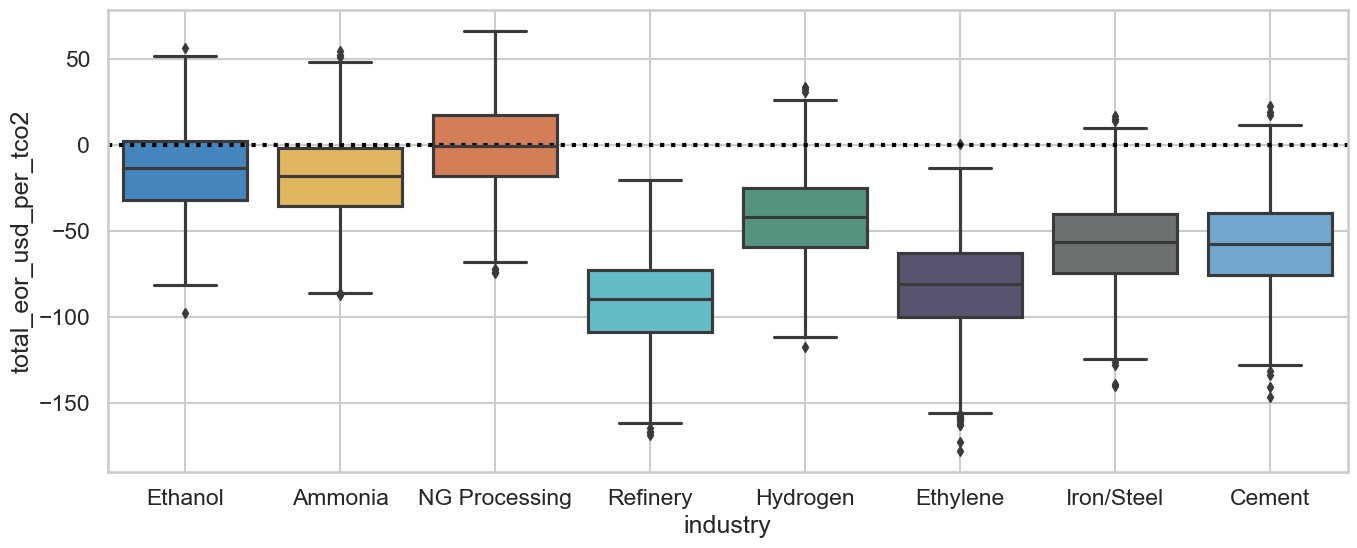

In [367]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")

palette = {
    "Ethanol": rgb_tuple(68, 133, 189),
    "Ammonia": rgb_tuple(224, 182, 96),
    "NG Processing": rgb_tuple(211, 126, 87),
    "Refinery": rgb_tuple(99, 188, 200),
    "Hydrogen": rgb_tuple(84, 147, 127),
    "Ethylene": rgb_tuple(88, 83, 111),
    "Iron/Steel": rgb_tuple(110, 113, 114),
    "Cement": rgb_tuple(115, 167, 208),
}
hue_order = list(palette.keys())
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.boxplot(
    ax=ax,
    data=scenarios_df.loc[
        (scenarios_df.brent_since_yr == "1987") & (scenarios_df.well_type == "existing")
    ],
    x="industry",
    y="total_eor_usd_per_tco2",
    # hue="well_type",
    palette=palette,
    order=hue_order,
    saturation=1,
)
plt.plot([-0.5, 7.5], [0, 0], "k", lw=3, ls=":")
ax.set_xlim([-0.5, 7.5])
ax.grid(True)

### Figure comparing distributions for ensembles for new and existing wells

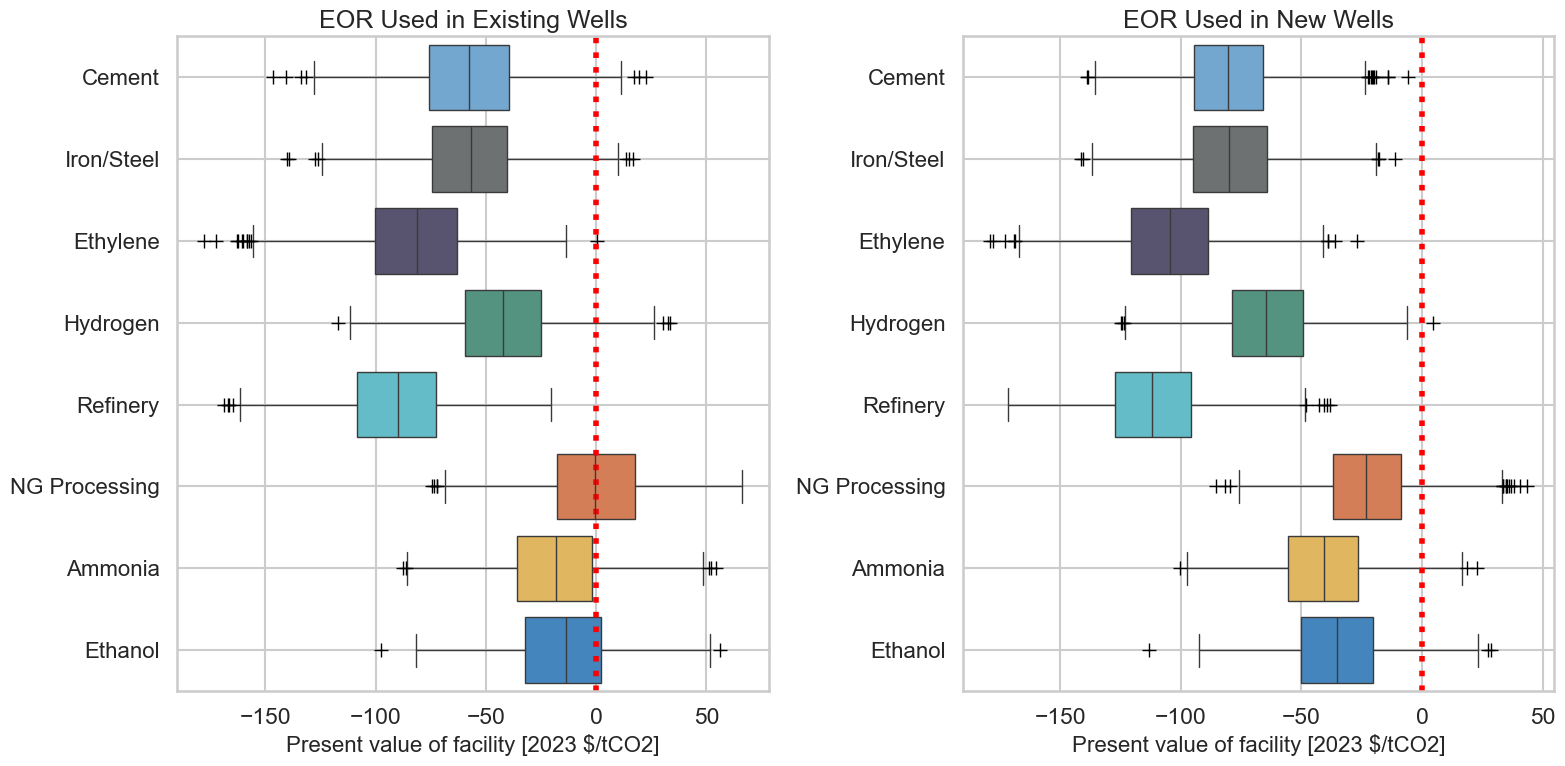

In [377]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")

palette = {
    "Ethanol": rgb_tuple(68, 133, 189),
    "Ammonia": rgb_tuple(224, 182, 96),
    "NG Processing": rgb_tuple(211, 126, 87),
    "Refinery": rgb_tuple(99, 188, 200),
    "Hydrogen": rgb_tuple(84, 147, 127),
    "Ethylene": rgb_tuple(88, 83, 111),
    "Iron/Steel": rgb_tuple(110, 113, 114),
    "Cement": rgb_tuple(115, 167, 208),
}
hue_order = list(palette.keys())
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
flierprops = dict(
    marker="+", markerfacecolor="None", markersize=10, markeredgecolor="black"
)
for i, well_type in enumerate(["existing", "new"]):
    sns.boxplot(
        ax=axes[i],
        data=scenarios_df.loc[
            (scenarios_df.brent_since_yr == "1987")
            & (scenarios_df.well_type == well_type)
        ],
        y="industry",
        x="total_eor_usd_per_tco2",
        palette=palette,
        order=hue_order,
        saturation=1,
        flierprops=flierprops,
        linewidth=1,
    )
    plt.subplot(1, 2, i + 1)
    plt.plot([0, 0], [-0.5, 7.5], "r", lw=4, ls=":")
    axes[i].set_ylim([-0.5, 7.5])
    axes[i].grid(True)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("Present value of facility [2023 $/tCO2]", fontsize=16)
    l = axes[i].get_yticklabels()
    axes[i].set_yticklabels(labels=l, fontsize=16)
    axes[i].set_title("EOR Used in " + well_type.title() + " Wells")
fig.tight_layout()

### Figure comparing distributions for ensembles for new and existing wells, separating by years of brent sampled

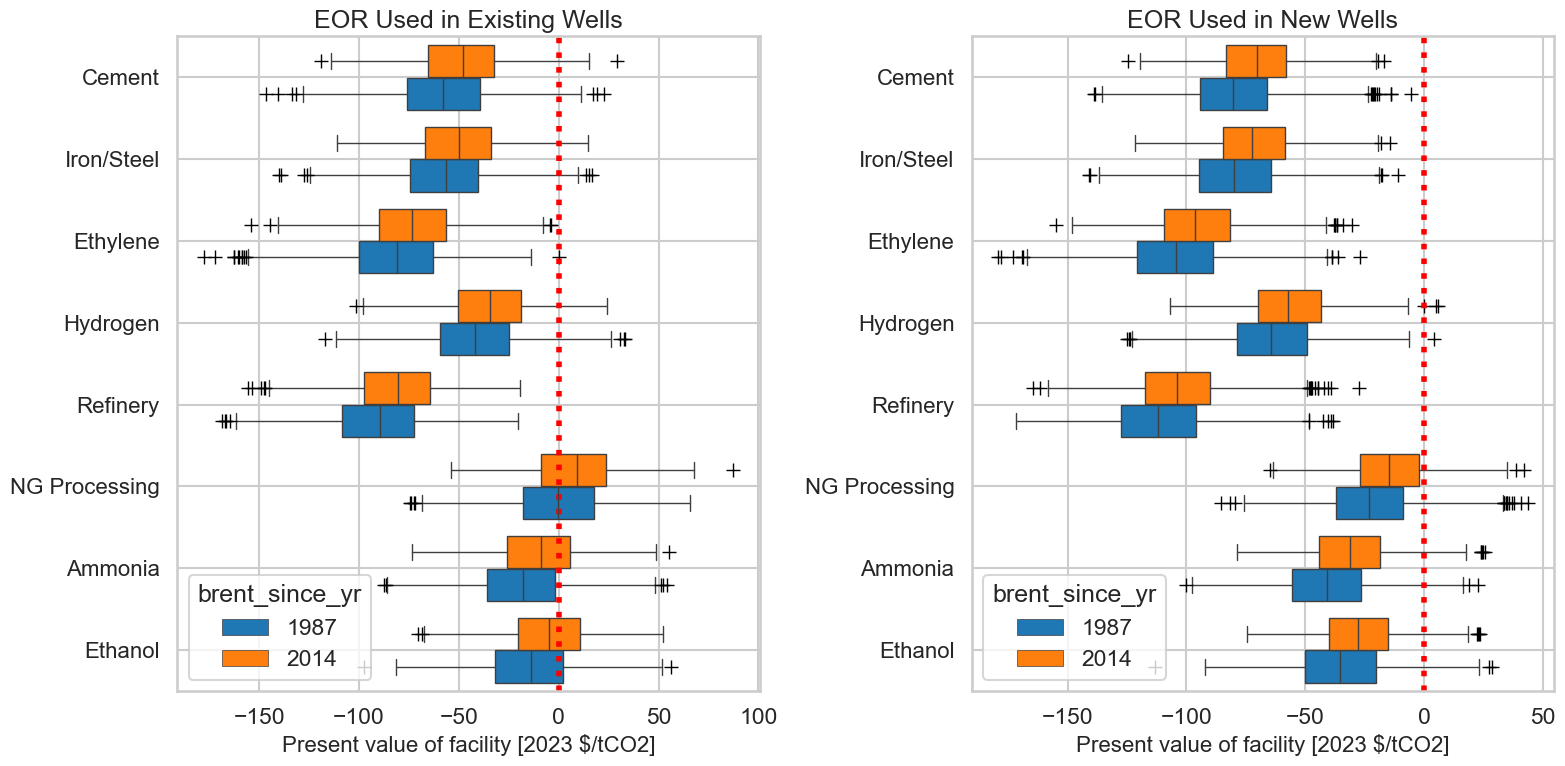

In [370]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")

palette = {
    "Ethanol": rgb_tuple(68, 133, 189),
    "Ammonia": rgb_tuple(224, 182, 96),
    "NG Processing": rgb_tuple(211, 126, 87),
    "Refinery": rgb_tuple(99, 188, 200),
    "Hydrogen": rgb_tuple(84, 147, 127),
    "Ethylene": rgb_tuple(88, 83, 111),
    "Iron/Steel": rgb_tuple(110, 113, 114),
    "Cement": rgb_tuple(115, 167, 208),
}
hue_order = list(palette.keys())
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
flierprops = dict(
    marker="+", markerfacecolor="None", markersize=10, markeredgecolor="black"
)
for i, well_type in enumerate(["existing", "new"]):
    sns.boxplot(
        ax=axes[i],
        data=scenarios_df.loc[
            # (scenarios_df.brent_since_yr == "1987") &
            (scenarios_df.well_type == well_type)
        ],
        y="industry",
        x="total_eor_usd_per_tco2",
        hue="brent_since_yr",
        # palette=palette,
        order=hue_order,
        saturation=1,
        flierprops=flierprops,
        linewidth=1,
    )
    plt.subplot(1, 2, i + 1)
    plt.plot([0, 0], [-0.5, 7.5], "r", lw=4, ls=":")
    axes[i].set_ylim([-0.5, 7.5])
    axes[i].grid(True)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("Present value of facility [2023 $/tCO2]", fontsize=16)
    l = axes[i].get_yticklabels()
    axes[i].set_yticklabels(labels=l, fontsize=16)
    axes[i].set_title("EOR Used in " + well_type.title() + " Wells")
fig.tight_layout()

### Write out a summary table for ensemble

In [375]:
scenarios_df["eor_gt_0"] = [x > 0 for x in scenarios_df.total_eor_usd_per_tco2]
scenarios_df["gs_gt_0"] = [x > 0 for x in scenarios_df.total_gs_usd_per_tco2]

scenarios_df[
    [
        "industry",
        "brent_since_yr",
        "well_type",
        "eor_gt_0",
        "gs_gt_0",
        "total_eor_usd_per_tco2",
        "total_gs_usd_per_tco2",
    ]
].loc[scenarios_df.brent_since_yr == "1987"].groupby(
    ["brent_since_yr", "industry", "well_type"]
).mean().to_clipboard()